[View in Colaboratory](https://colab.research.google.com/github/skyler237/deep_learning/blob/master/lab2/CS501R_Lab2.ipynb)

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm


    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59e3a000 @  0x7fd9ed5b91c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.6MB/s 
    100% |████████████████████████████████| 2.0MB 8.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

loss=0.0956: 100%|██████████| 2000/2000 [00:28<00:00, 69.23it/s]


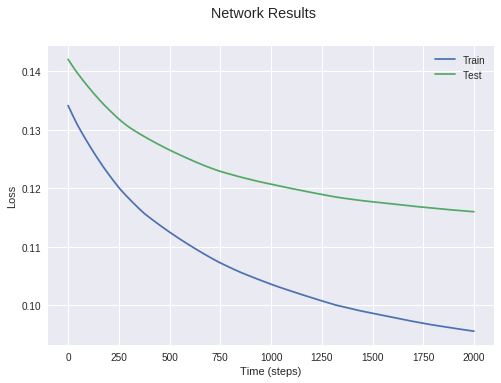

In [44]:
class MyNetwork(nn.Module):
  def __init__(self, dataset):
    super().__init__()
    x, y = dataset[0]
    channels, height, width = x.size()
    output_size = y.size(0)
    hidden_size = 2*output_size
    
    self.model = nn.Sequential(
        nn.Linear(channels * height * width, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    
  def forward(self, x):
    batch_size = x.size(0)
    x_flattened = x.view(batch_size, -1)
    output = self.model(x_flattened)
    return output
  
  
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train, 
                                      transform=transforms.ToTensor(),
                                      download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    y_out = torch.eye(10)[y]
    return x, y_out
  
  def __len__(self):
    return 10#len(self.data)
 

  
class Trainer:
  def __init__(self):
    self.train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
    self.train_dataloader = DataLoader(self.train_dataset, batch_size=10, pin_memory=True)
    
    self.test_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
    self.test_dataloader = DataLoader(self.test_dataset, batch_size=10, pin_memory=True)
    
    self.model = MyNetwork(self.train_dataset).cuda()
    self.optimizer = optim.SGD(self.model.parameters(), lr=0.0001)
    self.criterion = nn.MSELoss()
    self.training_losses = []
    self.test_losses = []
    
    self.init_plotter()
    
  def train(self, epochs=2000):
    train_status_bar = tqdm(total=len(self.train_dataloader)*epochs, position=0)
    self.test_counter = 0
    for epoch in range(epochs):
      for x, y_true in self.train_dataloader:
        # Convert to cuda
        x, y_true = x.cuda(async=True), y_true.cuda(async=True)

        # Zero out the gradient
        self.optimizer.zero_grad()

        # Get estimate
        y_estimate = self.model(x)

        loss = self.criterion(y_estimate, y_true)
        self.training_losses.append(loss.item())
        train_status_bar.set_description('loss={:.4f}'.format(loss.item()))
        train_status_bar.update(1)
          
        loss.backward()
        self.optimizer.step()
      self.test()
    train_status_bar.close()
    self.plot_losses()
      
  def test(self):
    for x, y_true in self.test_dataloader:
        # Convert to cuda
        x, y_true = x.cuda(async=True), y_true.cuda(async=True)

        # Get estimate
        y_estimate = self.model(x)
        loss = self.criterion(y_estimate, y_true)
        self.test_losses.append(loss.item())
  
  def init_plotter(self):
    self.figure, self.ax = plt.subplots()
    self.figure.suptitle('Network Results')
    plt.xlabel('Time (steps)')
    plt.ylabel('Loss')
    
  def plot_losses(self):
    self.ax.plot(self.training_losses, label='Train')
    self.ax.plot(self.test_losses, label='Test')
    self.ax.legend()
    plt.show()
  
trainer = Trainer()
trainer.train()
trainer.test()